### Problem Definition
- we have front,read and side sensors
- LIDAR : light detection and ranging
    - tries to get 3D geometry around the car
    - data is expensive to collect
- radar sensors on front and back for distance measurement
- GPS 
- Ultrasonic sensors
 
problem
- traffic rules
- avoid collision

Simplified version of the problem
- from camera feed, can we predict steering angle ?
- predicting steering angle can be thought of as regression problem
- ie. we have to solve series/seq of image -> seq of steering angle

### Open Datasets
- Comma.ai is a startup which provides data
- data is uncompressed 80gb and compressed 45 GB
https://github.com/commaai/research

- one more data is from Udacity : 200 gb
https://github.com/udacity/self-driving-car/tree/master/datasets

- Baidu
http://data.apollo.auto/?locale=en-us&lang=en

- dash cam data and steering angle data from obd in car
- Sully Chen is the person
- data is approx 2 GB
https://github.com/SullyChen/Autopilot-TensorFlow

### Data
folders
- driving_dataset folder contrains images from front camera and steering angles
- logs : when we train a model all logs are here
- save : final deep learning model is saved here

driving_dataset
- we have images and data.txt file
    - data.txt will give steering angle for every image
- camera takes apporx 30 images per sec
    - we have 45,406 images
    - we have 25 mins of recording
    - 30*60*25 = 45K images
    

### Train-test split
- we have 45406 images and steering angles
    - there is a sequence of data, ie. this is a temporal data
- so we will do time based splitting 
    - 80% train data, 20% test data

In [1]:
from __future__ import division
import os
import random
from scipy import pi
from itertools import islice
import numpy as np


DATA_FOLDER = './data/self-driving/Autopilot-TensorFlow-master/driving_dataset/'
TRAIN_FILE = os.path.join(DATA_FOLDER,'data.txt')

LIMIT = 20000
split = 0.8
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in islice(fp,LIMIT):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        y.append(float(angle) * pi / 180 )

y = np.array(y)
print("Completed processing data.txt")

# since we have complete data, we will do 70:30 split
split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]

Completed processing data.txt


In [2]:
# plotting histogram
# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 640x480 with 1 Axes>

Observations
- these two histograms are not properly overlapping as we have done time based splitting and not random splitting
- most of the time steering angle is at 0
    - most value in range of -2 to 2 
    - this is because we use radians instead of degree, so this is atype of normalization we did

### Simple base line model

In [3]:
train_mean_y = np.mean(train_y)
# this is a regression problem
print("MSE train (mean) ",np.mean(np.square(test_y -train_mean_y)))
print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


MSE train (mean)  0.10156191740248467
Test_MSE(ZERO):0.082492


### Using deep learning as regression

** Getting and splitting data **

In [4]:
import scipy.misc
import random
import numpy as np
import matplotlib.pyplot as plt

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
count = 0
with open("./data/self-driving/Autopilot-TensorFlow-master/driving_dataset/data.txt") as f:
    for line in f:
        xs.append("./data/self-driving/Autopilot-TensorFlow-master/driving_dataset/" + line.split()[0])
        ys.append(float(line.split()[1])*scipy.pi/180)


In [5]:
# getting number of images
num_images = len(xs)

# train test split
train_xs = xs[:int(len(xs)*0.7)]
train_ys = ys[:int(len(ys)*0.7)]

val_xs = xs[-int(len(xs)*0.3):]
val_ys = xs[-int(len(ys)*0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_ys)

print(num_train_images)
print("gettitng images")
np.array(train_xs).shape

31784
gettitng images


(31784,)

In [6]:
int(len(xs))

45406

13621
shape of image is :  (256, 455, 3)


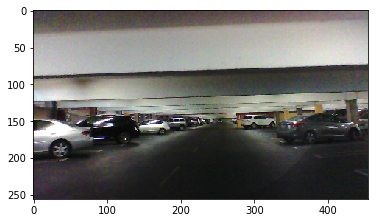

In [7]:
import imageio
print(num_val_images)
img = imageio.imread(train_xs[0])
print("shape of image is : ",img.shape)
plt.imshow(img)
plt.show()

** Image **

- image is height x width x channels
- we will chop of the top part a bit
    - height is 256 pixels
        - img is (256, 455, 3)
    - we will keep the bottom 150
        - now img is (150, 455, 3)
    - then we will resize the image to make it smaller 
        - resize to (66, 200, 3)
        

we will have batch gradient descent, so we need a method that will provide us with batches of data


In [9]:
from scipy.misc import imresize
from scipy.misc import imread

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x =  imresize(imageio.imread(train_xs[(train_batch_pointer+i) % num_train_images])[-150:], [66,200])
        x_out.append(x/255.0)
        y = train_ys[(train_batch_pointer+i) % num_train_images]
        y_out.append([y])
    train_batch_pointer += batch_size
    return np.array(x_out), np.array(y_out)

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x = imresize(imageio.imread(val_xs[(val_batch_pointer+i)% num_val_images])[-150:], [66,200])
        x_out.append(x/255.0)
        y = val_ys[(val_batch_pointer+i) % num_val_images]
        y_out.append([y])
    val_batch_pointer += batch_size
    return np.array(x_out), np.array(y_out)

- In Nvidea's end to end self driving
    - no max pool and no batch normalization and no dropouts
    - at final output neuron linear or taninv ( atan) function
    
- Implementation of this paper
https://devblogs.nvidia.com/deep-learning-self-driving-cars/

In [10]:
# building the network
import tensorflow as tf
import scipy

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2, name="output_y") #scale the atan output


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
import os
from tensorflow.core.protobuf import saver_pb2

In [ ]:
LOGDIR = './save/initialtry/'
sess = tf.InteractiveSession()
print("session started")
L2NormConst = 0.001

# this will give a list of all variables
train_vars = tf.trainable_variables()

# loss is sum(yi-yi^)^2 + L2 loss on all weights
loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

sess.run(tf.global_variables_initializer())

#create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

#merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

from sklearn import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # train over the dataset about 30 times
    for epoch in range(epochs):
        for i in range(int(num_images/batch_size)):
            xs, ys = LoadTrainBatch(batch_size)
            train_step.run(feed_dict={x: xs , y_: ys, keep_prob: 0.8})
            if i % 10 == 0:
                xs1, ys1 = LoadTrainBatch(batch_size)
                loss_value = loss.eval(feed_dict={x:xs1, y_: ys1, keep_prob:0.8})
                print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

            if i % batch_size == 0:
                if not os.path.exists(LOGDIR):
                    os.makedirs(LOGDIR)
                checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
                filename = saver.save(sess, checkpoint_path)
        print("Model saved in file: %s" % filename)
sess.close()

session started
Epoch: 0, Step: 0, Loss: 6.60495
Epoch: 0, Step: 10, Loss: 10.9035
Epoch: 0, Step: 20, Loss: 6.12581
Epoch: 0, Step: 30, Loss: 6.05488
Epoch: 0, Step: 40, Loss: 6.25779
Epoch: 0, Step: 50, Loss: 6.09142
Epoch: 0, Step: 60, Loss: 5.8752
Epoch: 0, Step: 70, Loss: 5.8236
Epoch: 0, Step: 80, Loss: 5.77841
Epoch: 0, Step: 90, Loss: 5.72773
Epoch: 0, Step: 100, Loss: 5.66646
Epoch: 0, Step: 110, Loss: 5.88462
Epoch: 0, Step: 120, Loss: 5.56826
Epoch: 0, Step: 130, Loss: 5.55759
Epoch: 0, Step: 140, Loss: 5.62506
Epoch: 0, Step: 150, Loss: 5.50761
Epoch: 0, Step: 160, Loss: 5.39024
Epoch: 0, Step: 170, Loss: 5.33736
Epoch: 0, Step: 180, Loss: 5.31464
Epoch: 0, Step: 190, Loss: 5.31859
Epoch: 0, Step: 200, Loss: 5.20998
Epoch: 0, Step: 210, Loss: 5.17604
Epoch: 0, Step: 220, Loss: 5.15052
Epoch: 0, Step: 230, Loss: 5.08715
Epoch: 0, Step: 240, Loss: 5.92392
Epoch: 0, Step: 250, Loss: 5.07971
Epoch: 0, Step: 260, Loss: 4.97217
Epoch: 0, Step: 270, Loss: 4.92542
Epoch: 0, Step: 2

Epoch: 2, Step: 310, Loss: 2.95411
Epoch: 2, Step: 320, Loss: 2.94193
Epoch: 2, Step: 330, Loss: 3.0085
Epoch: 2, Step: 340, Loss: 2.98824
Epoch: 2, Step: 350, Loss: 2.9062
Epoch: 2, Step: 360, Loss: 2.88774
Epoch: 2, Step: 370, Loss: 2.88423
Epoch: 2, Step: 380, Loss: 5.797
Epoch: 2, Step: 390, Loss: 3.95725
Epoch: 2, Step: 400, Loss: 2.82448
Epoch: 2, Step: 410, Loss: 2.86262
Epoch: 2, Step: 420, Loss: 2.76493
Epoch: 2, Step: 430, Loss: 3.2713
Epoch: 2, Step: 440, Loss: 2.73509
Epoch: 2, Step: 450, Loss: 5.76791
Epoch: 2, Step: 460, Loss: 2.70201
Epoch: 2, Step: 470, Loss: 2.7672
Epoch: 2, Step: 480, Loss: 2.67415
Epoch: 2, Step: 490, Loss: 2.66489
Epoch: 2, Step: 500, Loss: 2.79134
Epoch: 2, Step: 510, Loss: 2.65086
Epoch: 2, Step: 520, Loss: 2.65563
Epoch: 2, Step: 530, Loss: 2.64768
Epoch: 2, Step: 540, Loss: 2.58562
Epoch: 2, Step: 550, Loss: 2.57837
Epoch: 2, Step: 560, Loss: 2.5491
Epoch: 2, Step: 570, Loss: 2.677
Epoch: 2, Step: 580, Loss: 2.56257
Epoch: 2, Step: 590, Loss: 2.